Loading and Processing Images: 100%|███████████████████████████████████████████████| 8005/8005 [01:35<00:00, 83.53it/s]


Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END pca__n_components=50, svm__C=0.1, svm__kernel=linear; total time=   9.9s
[CV] END pca__n_components=50, svm__C=0.1, svm__kernel=linear; total time=   9.9s
[CV] END pca__n_components=50, svm__C=0.1, svm__kernel=linear; total time=   9.8s
[CV] END ..pca__n_components=50, svm__C=0.1, svm__kernel=rbf; total time=   9.1s
[CV] END ..pca__n_components=50, svm__C=0.1, svm__kernel=rbf; total time=  10.1s
[CV] END ..pca__n_components=50, svm__C=0.1, svm__kernel=rbf; total time=   8.5s
[CV] END .pca__n_components=50, svm__C=0.1, svm__kernel=poly; total time=   7.2s
[CV] END .pca__n_components=50, svm__C=0.1, svm__kernel=poly; total time=   7.9s
[CV] END .pca__n_components=50, svm__C=0.1, svm__kernel=poly; total time=   7.0s
[CV] END .pca__n_components=50, svm__C=1, svm__kernel=linear; total time=  22.1s
[CV] END .pca__n_components=50, svm__C=1, svm__kernel=linear; total time=  20.6s
[CV] END .pca__n_components=50, svm__C=1, svm

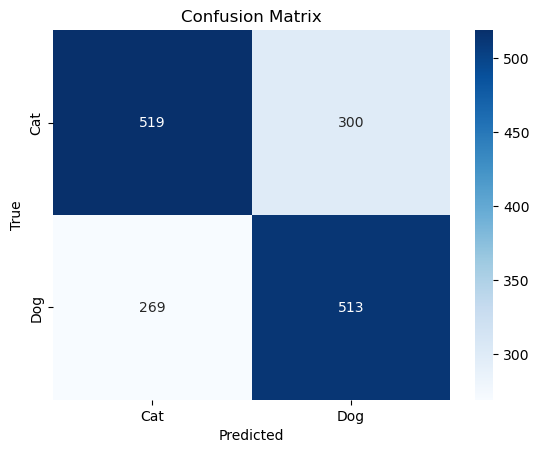

Model saved to C:\Users\HEMANTH\Documents\prodigy\svm_model.pkl


In [17]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib

# Define dataset paths
dataset_dir = r"C:\Users\Devender\Documents\prodigy"
train_dir = os.path.join(dataset_dir, "train")

# Check if the path exists
if not os.path.exists(train_dir):
    raise FileNotFoundError(f"{train_dir} not found. Ensure dataset is extracted correctly.")

# Initialize parameters
image_size = (50, 50)  # Resize images to 50x50
categories = {'cat': 0, 'dog': 1}  # Labels: cat -> 0, dog -> 1

# Preprocess the images: resize, normalize, and flatten
def load_images_from_folder(folder):
    features, labels = [], []
    
    for filename in tqdm(os.listdir(folder), desc="Loading and Processing Images"):
        if filename.startswith('cat'):
            label = categories['cat']
        elif filename.startswith('dog'):
            label = categories['dog']
        else:
            continue
        
        # Read the image
        img_path = os.path.join(folder, filename)
        image = cv2.imread(img_path)
        
        # Resize, normalize, and flatten the image
        image_resized = cv2.resize(image, image_size)
        image_normalized = image_resized / 255.0  # Normalize pixel values
        image_flattened = image_normalized.flatten()  # Flatten the image
        
        # Append features and labels
        features.append(image_flattened)
        labels.append(label)
    
    return np.array(features), np.array(labels)

# Load the training images
features, labels = load_images_from_folder(train_dir)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle=True, random_state=42)

# Clear up some memory
del features
del labels

# Define the PCA and SVM pipeline
pca = PCA()  # We'll tune the number of components
svm = SVC()  # Support Vector Classifier

# Create a pipeline
pipeline = Pipeline([
    ('pca', pca),
    ('svm', svm)
])

# Set up parameter grid for GridSearchCV
param_grid = {
    'pca__n_components': [50, 100, 150],  # Tune the number of components for PCA
    'svm__kernel': ['linear', 'rbf', 'poly'],  # Tune the SVM kernel
    'svm__C': [0.1, 1, 10]  # Regularization parameter for SVM
}

# Perform GridSearchCV to find the best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# Use the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Evaluate on test set
y_pred = best_model.predict(X_test)

# Print classification report
target_names = ['Cat', 'Dog']
print(classification_report(y_test, y_pred, target_names=target_names))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Save the model
model_file_path = os.path.join(dataset_dir, "svm_model.pkl")
joblib.dump(best_model, model_file_path)
print(f"Model saved to {model_file_path}")
